## 1. Библиотеки 

In [ ]:
import os
import random
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
def random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        
random_seed(1702)

## 2. Настройки конфигурации

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

val_img_dir = "../input/sartorius-cell-instance-segmentation/test"
train_img_dir = "../input/sartorius-cell-instance-segmentation/train"
train_csv_dir = "../input/sartorius-cell-instance-segmentation/train.csv"

width = 704
height = 520
n_epochs = 30
batch_size = 2
momentum = 0.9
learning_rate = 0.001
weight_decay = 0.0005 
num_box_detections = 540

min_score_dict = {1: 0.55, 2: 0.75, 3: 0.5}
cell_dict = {"astro": 1, "cort": 2, "shsy5y": 3}
mask_threshold_dict = {1: 0.55, 2: 0.75, 3:  0.6}

NORMALIZE = True
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

## 3. Вспомогательные функции 
 

#### Источники: 
- https://www.kaggle.com/inversion/run-length-decoding-quick-start
- https://www.kaggle.com/theoviel/competition-metric-map-iou
- https://www.kaggle.com/abhishek/maskrcnn-utils

In [ ]:
# Ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    maskimg = np.zeros((height, width))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg

def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []   
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks

In [ ]:
# Ref: https://www.kaggle.com/theoviel/competition-metric-map-iou
        
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union
    
    return iou  

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]
            
        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = mask_threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [ ]:
# Ref https://www.kaggle.com/abhishek/maskrcnn-utils

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class GaussianBlur:
    def __init__(self, prob):
        self.prob = prob
    
    def __call__(self, image, target): 
        if random.random() < self.prob:
            image = F.gaussian_blur(image, kernel_size=(5, 9), sigma=(0.1, 1.5))
        
        return image, target

def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())
    
    # Data augmentation for train
    if train: 
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))
        transforms.append(GaussianBlur(0.2))

    return Compose(transforms)

## 4. Данные

### a. Данные

In [ ]:
class SatoriusDataset(Dataset): 
    def __init__(self, csv_file, image_dir, transform=None, resize=None):
        self.transform = transform
        self.csv = csv_file 
        self.resize = True if resize else False 
        
        # resize is the factor, e.g 1.2, 1.3, ... 
        if self.resize: 
            self.height = int(height * resize)
            self.width = int(width * resize)
        else: 
            self.height = height
            self.width = width
        
        # collections.defaultdict returns an empty dict when the key is not found
        self.image_info = collections.defaultdict(dict)
        
        # group by id then cell, and get the annotations 
        csv_groupby = self.csv.groupby(['id', 'cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
        
        
        # image_info is the replacement of csv 
        # use image_info to iterate
        for index, row in csv_groupby.iterrows(): 
            self.image_info[index] = { 
                'image_id': row['id'],
                'image_path': os.path.join(image_dir, row['id'] + '.png'),
                'annotations': row['annotation'],
                'cell_type': cell_dict[row['cell_type']],
            }        
        
    def __len__(self): 
        return len(self.image_info)

    def get_boxes(self, mask):
        # the size of the mask is [w, h] and the values are True and False
        # using np.where will return the location of the True value in the mask 
        mask = np.where(mask)

        # locations of the bounding box 
        x_min = np.min(mask[1])
        x_max = np.max(mask[1])
        y_min = np.min(mask[0])
        y_max = np.max(mask[0])

        return [x_min, y_min, x_max, y_max]

    def __getitem__(self, idx): 
        item = self.image_info[idx]

        image = cv2.imread(item['image_path'], cv2.IMREAD_COLOR)        
        if self.resize: 
            image = cv2.resize(image, (self.width, self.height))
        
        # height goes before width because of rle_decode()
        masks = np.zeros((len(item['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []

        for i, mask in enumerate(item['annotations']): 
            mask = rle_decode(mask, (height, width))

            if self.resize: 
                mask = cv2.resize(mask, (self.width, self.height))
                
            # the mask only contains true and false, which are 1 and 0
            mask = np.array(mask) > 0
            masks[i,:,:] = mask
            boxes.append(self.get_boxes(mask))

        labels = [item['cell_type'] for _ in range(len(item['annotations']))]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # targets must have for the mask-rcnn
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
        }

        if self.transform: 
            image, target = self.transform(image, target)

        return image, target

### b. Построим график набора данных

img  :  (520, 704, 3)
boxes:  torch.Size([108, 4])
labels: torch.Size([108])
masks:  torch.Size([108, 520, 704])
labels:    tensor([1])


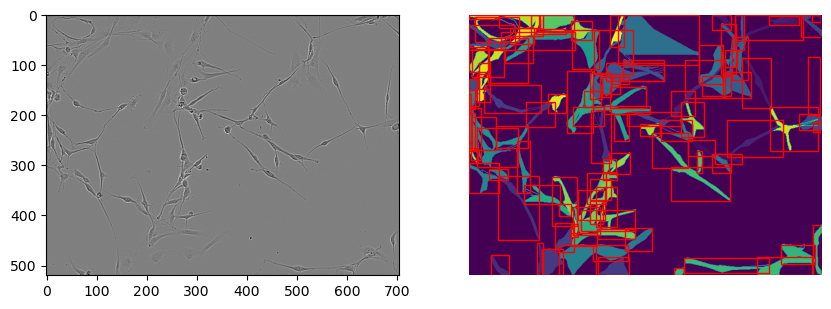

In [ ]:
test_dataset_csv = pd.read_csv(train_csv_dir)
test_dataset = SatoriusDataset(test_dataset_csv, train_img_dir)

test = test_dataset.__getitem__(1)
img = test[0]
target = test[1]

boxes = target['boxes']
masks = target['masks']
labels = target['labels']

print(f"img  :  {img.shape}")
print(f"boxes:  {boxes.shape}")
print(f"labels: {labels.shape}")
print(f"masks:  {masks.shape}")

print("labels:   ", labels.unique())

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(img)
ax[1].imshow(combine_masks(masks, 0))

for box in boxes:
    # box[1] - box[3] because y-axis is reversed
    ax[1].add_patch(patches.Rectangle((box[0], box[3]), box[2] - box[0], box[1] - box[3], linewidth=1, edgecolor='r', facecolor='none'))
    
plt.axis(False)
plt.show()

## 5. Модель 

In [ ]:
class MaskRCNN(nn.Module):
    def __init__(self, num_classes, pretrained_model=None):
        super().__init__()
        
        self.pretrained_model = pretrained_model
        
        if NORMALIZE: 
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                      box_detections_per_img=num_box_detections, 
                                                                      image_mean=RESNET_MEAN, 
                                                                      image_std=RESNET_STD)
        else:
            self.model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                      box_detections_per_img=num_box_detections)

        hidden_layer = 256
        
        # get the input features of the box_predictor 
        # replace the pretrained box_predictor layer with new FastRCNN
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
        
        # get the input features of the mask_predictor 
        # replace the pretrained mask_predictor layer with new MaskRCNN
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)
                
    def forward(self, x, y=None): 
        # in the training mode, the model needs both x and y (y is the target)
        # in the val mode, the model only needs x
        if y: 
            return self.model(x, y)
        
        return self.model(x)
    
#     def init_model(self):
#         if self.pretrained_model:
#             self.model.load_state_dict(self.pretrained_model, map_location=DEVICE)
        
#         print("Loaded pretrained weights")

## 6. Обучение

### a. Вспомогательные функции

In [ ]:
class Trainer:
    def __init__(self, model, optimizer, device, scheduler):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = DEVICE
        
        self.train_loss_mask = []
        self.train_loss_classifier = []
        self.train_loss = []
        self.val_loss_mask = []
        self.val_loss_classifier = []
        self.val_loss = []
        
    def fit(self, train_loader, val_loader, n_epochs):
        for epoch in range(n_epochs): 
            
            # train and val
            self.train_epoch(train_loader)            
            self.val_epoch(val_loader)
            
            if self.scheduler: 
                self.scheduler.step() 
            
            print(f"epoch {epoch + 1} train:  mask loss : {self.train_loss_mask[-1]:3f}, classifier loss:  {self.train_loss_classifier[-1]:3f}")
            print(f"epoch {epoch + 1} val:    mask loss : {self.val_loss_mask[-1]:3f},   classifier loss: {self.val_loss_classifier[-1]:3f}")
            print(f"epoch {epoch + 1}:        train loss: {self.train_loss[-1]:3f},      val_loss       : {self.val_loss[-1]:3f}")

            print('save model ...')
            torch.save(self.model.state_dict(), f'model-e{epoch + 1}.pt')

            print('\n\n')
                                
    def train_epoch(self, train_loader):
        self.model.train()
        self.train_loss_mask.append(0)
        self.train_loss_classifier.append(0)
        self.train_loss.append(0)

        for i, data in tqdm(enumerate(train_loader, 0)): 
            x, y = data
            x = list(img.to(self.device) for img in x)
            y = [{k: v.to(self.device) for k, v in t.items()} for t in y]
            
            self.optimizer.zero_grad()
            
            # in training mode, the model return the loss
            # in val mode, the model return the predictions
            losses = self.model(x, y)
            loss = sum(loss for loss in losses.values())
            loss.backward()
            self.optimizer.step()
            
            self.train_loss_mask[-1] += losses['loss_mask'].item()
            self.train_loss_classifier[-1] += losses['loss_classifier'].item()
            self.train_loss[-1] += loss.item()
        
        # gets the average
        self.train_loss_mask[-1] /= len(train_loader)
        self.train_loss_classifier[-1] /= len(train_loader)
        self.train_loss[-1] /= len(train_loader)
        
    def val_epoch(self, val_loader):
        self.val_loss_mask.append(0)
        self.val_loss_classifier.append(0)
        self.val_loss.append(0)

        for i, data in tqdm(enumerate(val_loader, 0)): 
            with torch.no_grad():
                x, y = data 
                x = list(img.to(self.device) for img in x)
                y = [{k: v.to(self.device) for k, v in t.items()} for t in y]
                
                # in training mode, the model return the loss
                # in val mode, the model return the predictions
                losses = model(x, y)
                loss = sum(loss for loss in losses.values())
                
                self.val_loss_mask[-1] += losses['loss_mask'].item()
                self.val_loss_classifier[-1] += losses['loss_classifier'].item()
                self.val_loss[-1] += loss.item()

        # gets the average
        self.val_loss_mask[-1] /= len(val_loader)
        self.val_loss_classifier[-1] /= len(val_loader)
        self.val_loss[-1] /= len(val_loader)

### b. Обучение

In [ ]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/cocopre/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

cp: cannot stat '../input/cocopre/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth': No such file or directory


In [ ]:
train_csv = pd.read_csv(train_csv_dir)

# the layout of the df_images would be: id, cell_type, annotation
# there would be one row for one image because each image only contains one cell_type
df_images = train_csv.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()

train_df, test_df = train_test_split(df_images, stratify=df_images['cell_type'], 
                                                  test_size=0.2,
                                                  random_state=1702)

# dataloader for training
train_df = train_csv[train_csv['id'].isin(train_df['id'])]
train_dataset = SatoriusDataset(train_df, train_img_dir, transform=get_transform(train=True))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                              num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# dataloader for validation
test_df = train_csv[train_csv['id'].isin(test_df['id'])]
test_dataset = SatoriusDataset(test_df, train_img_dir, transform=get_transform(train=False))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True,
                             num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
model = MaskRCNN(len(cell_dict))
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

trainer = Trainer(model, optimizer, DEVICE, lr_scheduler)
trainer.fit(train_dataloader, test_dataloader, n_epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 105MB/s]  


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 1 train:  mask loss : 0.402658, classifier loss:  0.510727
epoch 1 val:    mask loss : 0.328074,   classifier loss: 0.388487
epoch 1:        train loss: 1.924518,      val_loss       : 1.635536
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 2 train:  mask loss : 0.326484, classifier loss:  0.364518
epoch 2 val:    mask loss : 0.317368,   classifier loss: 0.329403
epoch 2:        train loss: 1.570247,      val_loss       : 1.503318
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 3 train:  mask loss : 0.321539, classifier loss:  0.348893
epoch 3 val:    mask loss : 0.317966,   classifier loss: 0.317327
epoch 3:        train loss: 1.523824,      val_loss       : 1.484064
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 4 train:  mask loss : 0.315943, classifier loss:  0.323047
epoch 4 val:    mask loss : 0.316025,   classifier loss: 0.326912
epoch 4:        train loss: 1.466498,      val_loss       : 1.489094
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 5 train:  mask loss : 0.314527, classifier loss:  0.322025
epoch 5 val:    mask loss : 0.309254,   classifier loss: 0.323170
epoch 5:        train loss: 1.450484,      val_loss       : 1.446956
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 6 train:  mask loss : 0.312315, classifier loss:  0.319454
epoch 6 val:    mask loss : 0.314349,   classifier loss: 0.302788
epoch 6:        train loss: 1.442335,      val_loss       : 1.450354
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 7 train:  mask loss : 0.309813, classifier loss:  0.308833
epoch 7 val:    mask loss : 0.307910,   classifier loss: 0.306700
epoch 7:        train loss: 1.414862,      val_loss       : 1.431156
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 8 train:  mask loss : 0.308447, classifier loss:  0.301527
epoch 8 val:    mask loss : 0.312437,   classifier loss: 0.296127
epoch 8:        train loss: 1.400795,      val_loss       : 1.404524
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 9 train:  mask loss : 0.308037, classifier loss:  0.288987
epoch 9 val:    mask loss : 0.310316,   classifier loss: 0.290061
epoch 9:        train loss: 1.360862,      val_loss       : 1.395611
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 10 train:  mask loss : 0.307189, classifier loss:  0.286954
epoch 10 val:    mask loss : 0.309951,   classifier loss: 0.289289
epoch 10:        train loss: 1.358667,      val_loss       : 1.408101
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 11 train:  mask loss : 0.306282, classifier loss:  0.283248
epoch 11 val:    mask loss : 0.309735,   classifier loss: 0.292875
epoch 11:        train loss: 1.350523,      val_loss       : 1.411929
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 12 train:  mask loss : 0.306796, classifier loss:  0.284414
epoch 12 val:    mask loss : 0.309137,   classifier loss: 0.289891
epoch 12:        train loss: 1.352009,      val_loss       : 1.399122
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 13 train:  mask loss : 0.305457, classifier loss:  0.283854
epoch 13 val:    mask loss : 0.308493,   classifier loss: 0.290045
epoch 13:        train loss: 1.347827,      val_loss       : 1.375561
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 14 train:  mask loss : 0.306019, classifier loss:  0.284635
epoch 14 val:    mask loss : 0.308354,   classifier loss: 0.286270
epoch 14:        train loss: 1.350820,      val_loss       : 1.382764
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 15 train:  mask loss : 0.305994, classifier loss:  0.282032
epoch 15 val:    mask loss : 0.309416,   classifier loss: 0.291004
epoch 15:        train loss: 1.342709,      val_loss       : 1.400948
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 16 train:  mask loss : 0.306749, classifier loss:  0.283239
epoch 16 val:    mask loss : 0.308915,   classifier loss: 0.291945
epoch 16:        train loss: 1.346808,      val_loss       : 1.397366
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 17 train:  mask loss : 0.306591, classifier loss:  0.281964
epoch 17 val:    mask loss : 0.308993,   classifier loss: 0.290720
epoch 17:        train loss: 1.344606,      val_loss       : 1.396374
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 18 train:  mask loss : 0.305438, classifier loss:  0.283858
epoch 18 val:    mask loss : 0.309676,   classifier loss: 0.290604
epoch 18:        train loss: 1.349210,      val_loss       : 1.397908
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 19 train:  mask loss : 0.305062, classifier loss:  0.281316
epoch 19 val:    mask loss : 0.308135,   classifier loss: 0.287163
epoch 19:        train loss: 1.339454,      val_loss       : 1.384982
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 20 train:  mask loss : 0.305758, classifier loss:  0.282544
epoch 20 val:    mask loss : 0.308138,   classifier loss: 0.289293
epoch 20:        train loss: 1.343304,      val_loss       : 1.394882
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 21 train:  mask loss : 0.305873, classifier loss:  0.282335
epoch 21 val:    mask loss : 0.310005,   classifier loss: 0.287439
epoch 21:        train loss: 1.342279,      val_loss       : 1.394005
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 22 train:  mask loss : 0.305148, classifier loss:  0.283377
epoch 22 val:    mask loss : 0.308849,   classifier loss: 0.290369
epoch 22:        train loss: 1.342798,      val_loss       : 1.399262
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 23 train:  mask loss : 0.305355, classifier loss:  0.281890
epoch 23 val:    mask loss : 0.307956,   classifier loss: 0.288934
epoch 23:        train loss: 1.341815,      val_loss       : 1.387071
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 24 train:  mask loss : 0.305816, classifier loss:  0.282033
epoch 24 val:    mask loss : 0.310279,   classifier loss: 0.288941
epoch 24:        train loss: 1.340974,      val_loss       : 1.396951
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 25 train:  mask loss : 0.305298, classifier loss:  0.281373
epoch 25 val:    mask loss : 0.308482,   classifier loss: 0.288232
epoch 25:        train loss: 1.338614,      val_loss       : 1.399867
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 26 train:  mask loss : 0.304660, classifier loss:  0.282804
epoch 26 val:    mask loss : 0.310080,   classifier loss: 0.285573
epoch 26:        train loss: 1.341042,      val_loss       : 1.392397
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 27 train:  mask loss : 0.304651, classifier loss:  0.281419
epoch 27 val:    mask loss : 0.308974,   classifier loss: 0.286353
epoch 27:        train loss: 1.337303,      val_loss       : 1.398509
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 28 train:  mask loss : 0.305440, classifier loss:  0.280636
epoch 28 val:    mask loss : 0.310373,   classifier loss: 0.287942
epoch 28:        train loss: 1.337657,      val_loss       : 1.393559
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 29 train:  mask loss : 0.305481, classifier loss:  0.280781
epoch 29 val:    mask loss : 0.306627,   classifier loss: 0.289402
epoch 29:        train loss: 1.339782,      val_loss       : 1.386198
save model ...





0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch 30 train:  mask loss : 0.305672, classifier loss:  0.280952
epoch 30 val:    mask loss : 0.307736,   classifier loss: 0.288560
epoch 30:        train loss: 1.343151,      val_loss       : 1.390069
save model ...





### c. График потерь

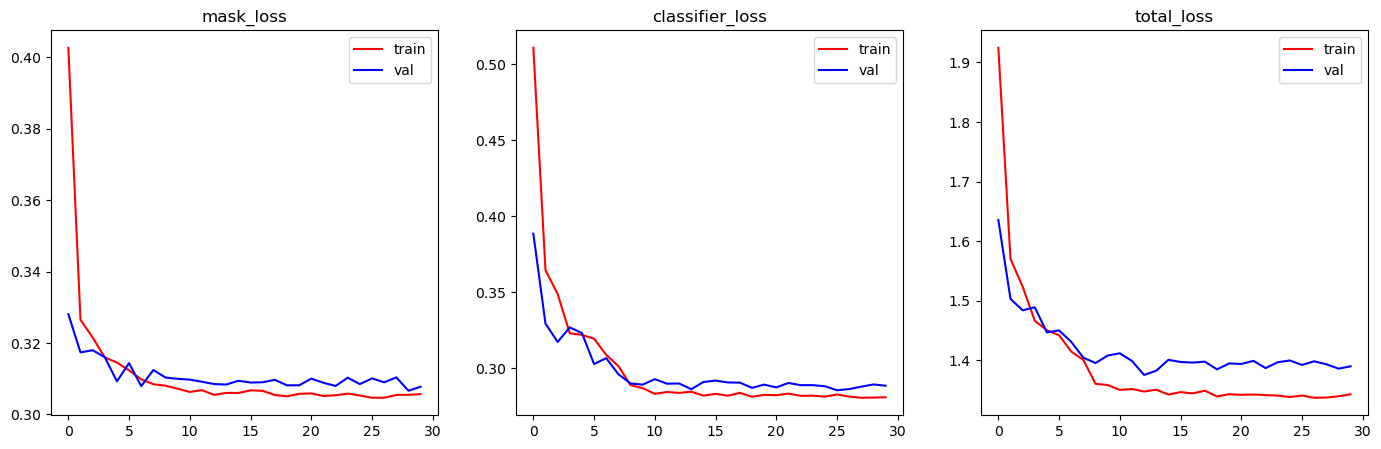

In [ ]:
train_loss_mask = trainer.train_loss_mask
train_loss_classifier = trainer.train_loss_classifier
train_loss = trainer.train_loss
val_loss_mask = trainer.val_loss_mask
val_loss_classifier = trainer.val_loss_classifier
val_loss = trainer.val_loss

fig, ax = plt.subplots(1, 3, figsize=(17, 5))
ax[0].plot(train_loss_mask, color='red', label="train")
ax[0].plot(val_loss_mask, color='blue', label="val")
ax[1].plot(train_loss_classifier, color='red', label="train")
ax[1].plot(val_loss_classifier, color='blue', label="val")
ax[2].plot(train_loss, color='red', label="train")
ax[2].plot(val_loss, color='blue', label="val")

ax[0].title.set_text("mask_loss")
ax[1].title.set_text("classifier_loss")
ax[2].title.set_text("total_loss")

ax[0].legend()
ax[1].legend()
ax[2].legend()

### d. Лучшая модель

In [ ]:
scores = pd.DataFrame()

for e in range(n_epochs): 
    model = MaskRCNN(len(cell_dict))
    model.load_state_dict(torch.load(f"model-e{e + 1}.pt"))
    model.to(DEVICE)
    scores.loc[e, "score"] = get_score(test_dataset, model)

best_model = ""
scores = scores.sort_values("score", ascending=False)

best_model = f'model-e{np.argmax(scores["score"]) + 1}.pt'

scores

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/122 [00:00<?, ?it/s]

,score
7,0.251489
14,0.251483
16,0.250304
24,0.250261
18,0.250207
23,0.250163
26,0.250147
25,0.250127
13,0.250116
29,0.250070


### e. Загружаем лучшую модель и тестируем

In [ ]:
try: 
    if best_model == "":
        best_model = "../input/satorius-models/model-e7.pt"
except: 
    best_model = "../input/satorius-models/model-e7.pt"
    
model = MaskRCNN(len(cell_dict))
model.load_state_dict(torch.load(best_model))
model.to(DEVICE)
print()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


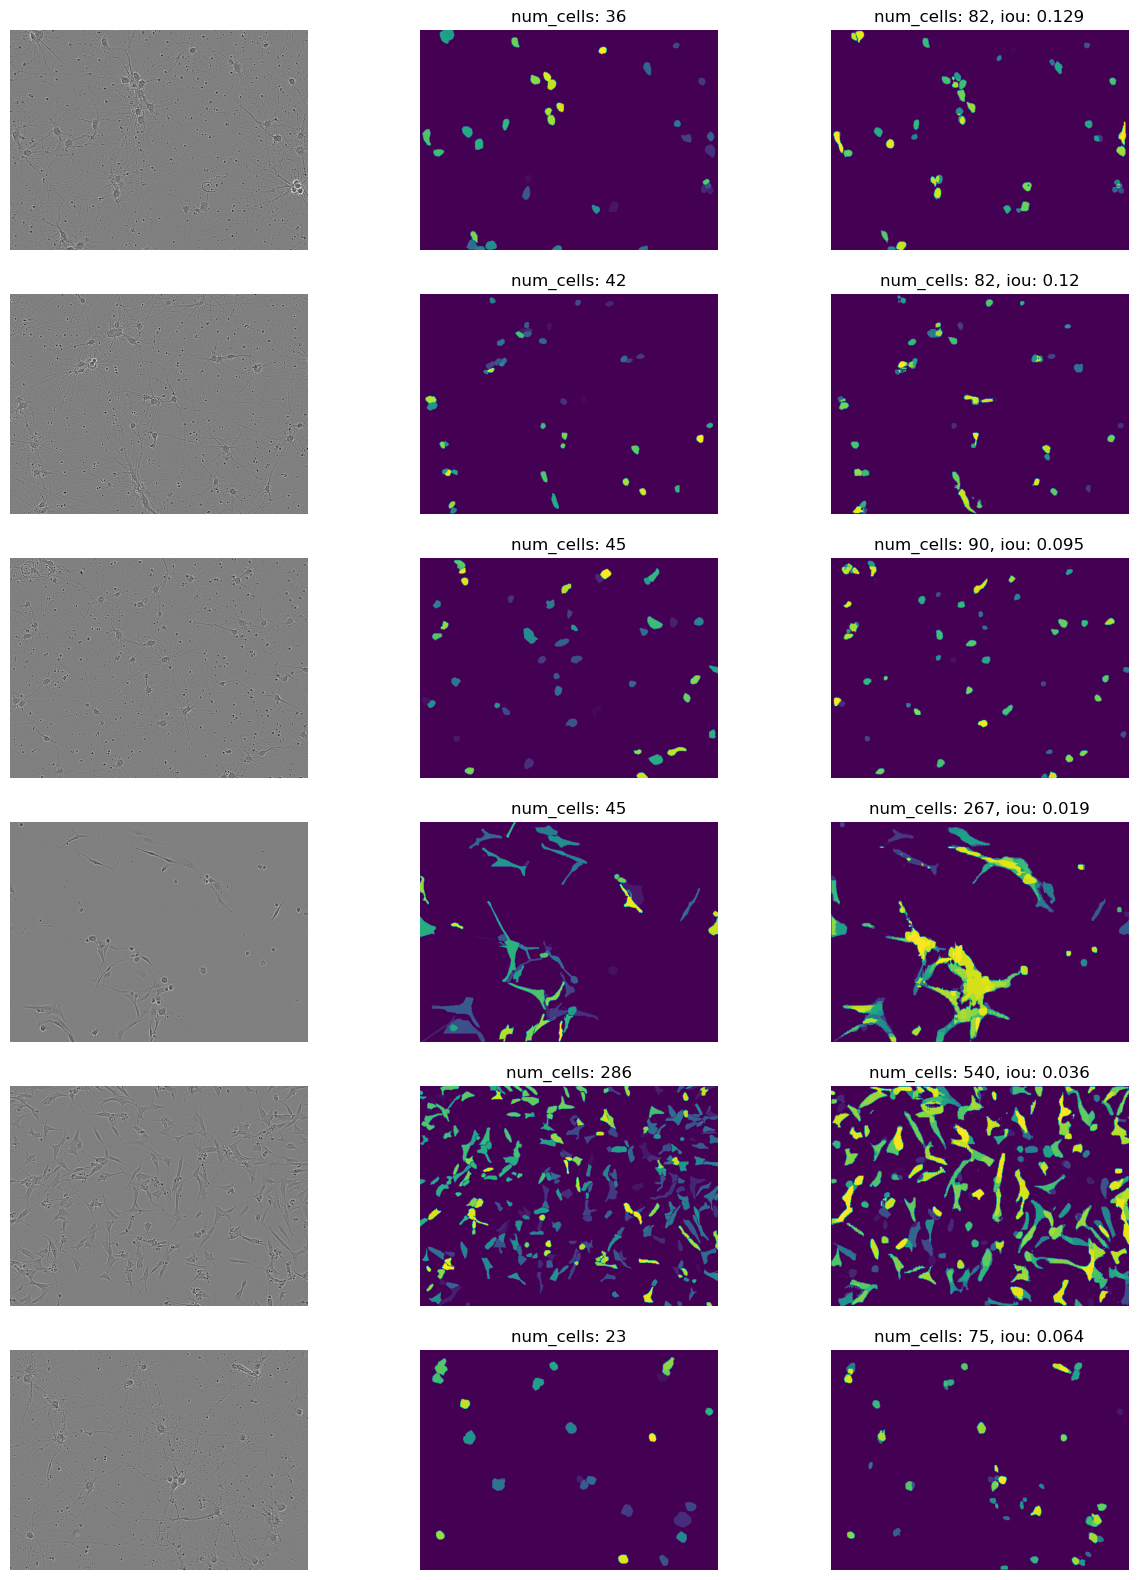

In [ ]:
model.eval()
test_dataset_temp = SatoriusDataset(test_df, train_img_dir)

# the number of image will be num_rows * 2 since batch = 2
num_rows = 3
fig, ax = plt.subplots(num_rows * batch_size, 3, figsize=(15, 20))

for i, data in enumerate(test_dataloader): 
    x, y = data
    x = list(img.to(DEVICE) for img in x)
    
    with torch.no_grad():
            predictions = model(x, None)
    
    for j in range(batch_size):
        original_img = test_dataset_temp.__getitem__(i * 2 + j)[0]
        
        # get the label with the highest frequency 
        label = np.array(np.unique(predictions[j]["labels"].cpu().numpy(), return_counts=True))
        label = label[0][np.argmax(label.T[:,1])]
        
        thresh_hold = mask_threshold_dict[label]
        
        original_mask = combine_masks(y[j]["masks"], 0)
        predicted_mask = combine_masks(predictions[j]["masks"].squeeze().cpu().numpy(), thresh_hold)
        
        iou_score = iou_map([original_mask],[predicted_mask])
        
        ax[i * 2 + j, 0].imshow(original_img)
        ax[i * 2 + j, 1].imshow(original_mask)
        ax[i * 2 + j, 2].imshow(predicted_mask)
        
        ax[i * 2 + j, 0].axis('off')
        ax[i * 2 + j, 1].axis('off')
        ax[i * 2 + j, 2].axis('off')

        ax[i * 2 + j, 1].title.set_text(f'num_cells: {len(y[j]["masks"])}')
        ax[i * 2 + j, 2].title.set_text(f'num_cells: {len(predictions[j]["masks"].squeeze().cpu().numpy())}, iou: {round(iou_score, 3)}')
        
    if i == num_rows - 1: 
        break

## 7. Делаем Submission на Kaggle

In [ ]:
class SatoriusSubmissionDataset(Dataset): 
    def __init__(self, image_dir, transform=None, resize=None):
        self.transform = transform
        self.resize = True if resize else False 
        self.image_dir = image_dir
        self.image_id = [path[:-4] for path in os.listdir(image_dir)]
        
        if self.resize: 
            self.height = int(height * resize)
            self.width = int(width * resize)
        
    def __len__(self): 
        return len(self.image_id)

    def __getitem__(self, idx): 
        image_id = self.image_id[idx]
        image = cv2.imread(os.path.join(self.image_dir, image_id + ".png"), cv2.IMREAD_COLOR)  

        if self.resize: 
            image = cv2.resize(image, (self.width, self.height))
        
        if self.transform: 
            image, _ = self.transform(image, target=None)

        return image, image_id

In [ ]:
submission_dataset = SatoriusSubmissionDataset(val_img_dir, transform=get_transform(train=False))
submission_dataloader = DataLoader(submission_dataset, batch_size=1, pin_memory=True,
                             num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
submission = []

for _, data in enumerate(submission_dataloader): 
    x, y = data
    x = list(img.to(DEVICE) for img in x)
    
    with torch.no_grad():
            predictions = model(x)[0]
    
    previous_masks = []
    
    # get the label with the highes frequency
    label = np.array(np.unique(predictions["labels"].cpu().numpy(), return_counts=True))
    label = label[0][np.argmax(label.T[:,1])]

    for i, mask in enumerate(predictions["masks"]):
        score = predictions["scores"][i].cpu().item()
        
        # compare the score with the threshold 
        if score > min_score_dict[label]:
            mask = mask.cpu().numpy()
            
            # compare the mask with the threshold and remove overlapping
            mask = mask > mask_threshold_dict[label]
            mask = remove_overlapping_pixels(mask, previous_masks)
            rle = rle_encoding(mask)
            
            previous_masks.append(mask)
            
            # the competition requires submission with the location of each cell in a picture as a row
            submission.append((y[0], rle))
            
    # if there is no rle_encoding for an image, simply append emtpy string since there is no mask
    all_ids = [image_id for image_id, rle in submission]
    if y[0] not in all_ids:
        submission.append((y[0], ""))
    
df_submission = pd.DataFrame(submission, columns=['id', 'predicted'])
df_submission.to_csv("submission.csv", index=False)
df_submission.head()

,id,predicted
0,7ae19de7bc2a,297512 1 297514 1 298215 6 298918 7 299622 7 3...
1,7ae19de7bc2a,72871 6 73575 7 74279 8 74983 9 75687 10 76391...
2,7ae19de7bc2a,1856 6 2560 7 3263 9 3967 10 4671 10 5375 11 6...
3,7ae19de7bc2a,978 9 1682 11 2386 12 3092 14 3796 15 4500 17 ...
4,7ae19de7bc2a,6773 8 7476 11 8179 12 8883 13 9587 13 10291 1...
